In [295]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [297]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=ec7f89ca7d966597523b6a08df14df21b41a4097cf6956c96524ea1063bd0058
  Stored in directory: c:\users\rober\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor
Note: you may need to restart the kernel to use updated packages.


In [298]:
import pandas as pd
import pandas
import matplotlib.pyplot as plt
import datetime
import re
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
File = pd.ExcelFile('DatosWoS.xlsx')
df=File.parse('Sheet1')


In [127]:
def convertfecha(month_name):
    datetime_object = datetime.datetime.strptime(month_name, "%b")
    month_number = datetime_object.month
    return month_number

In [277]:
df_year = df.sort_values('Año')
df_reorder = df_year.groupby(["Año","Mes"]).count()
df_back = df_reorder.reset_index()
df_back = df_back.drop(labels = 437, axis = 0)
df_fdf = pd.DataFrame(df_back.Titulo).copy()
df_fdf["fecha"] = df_back.Año + " " + df_back.Mes
df_fdf.reindex(columns = ["fecha","Titulo"])
df_fdf.rename({"Titulo" :"Publicaciones"},axis = 1)


,Publicaciones,fecha
0,155,(Early Apr
1,175,(Early Aug
2,148,(Early Dec
3,128,(Early Feb
4,139,(Early Jan
...,...,...
432,466,2022 Mar
433,4,2022 Mar-apr
434,172,2022 May
435,1,2022 May-jun


In [284]:
list_df = df_fdf.values.tolist()
print(list_df[0])
list_df_new = []
for i in range(len(list_df)):
    if any(ch.isdigit() for ch in list_df[i][1]) == True:
        list_df_new.append(list_df[i])
print(list_df_new[0])

[155, '(Early Apr']
[101, '2010 Apr']


In [285]:
for i in range(len(list_df_new)):
    if ("-" in list_df_new[i][1]) == True:
        month = list_df_new[i][1].split()[1]
        
        year = list_df_new[i][1].split()[0]
        year = year.replace(" ","")
        month = month.split("-")[0]
        new_value = year + " " + month
        for j in range(len(list_df_new)):
            if list_df_new[j][1] == new_value:
                list_df_new[j][0] += 1
    if ("." in list_df_new[i][1]) == True:
        month = list_df_new[i][1].split()[1]
        
        year = list_df_new[i][1].split()[0]
        year = year.replace(" ","")
        month = month.split(".")[0]
        new_value = year + " " + month
        for j in range(len(list_df_new)):
            if list_df_new[j][1] == new_value:
                list_df_new[j][0] += 1    
flist_df = []
for i in range(len(list_df_new)):
    if ("-" in list_df_new[i][1]) == False and ("." in list_df_new[i][1]) == False and ("Fal" in list_df_new[i][1]) == False and ("Sum" in list_df_new[i][1]) == False and ("Win" in list_df_new[i][1]) == False and  ("Spr" in list_df_new[i][1]) == False:
        flist_df.append(list_df_new[i])


In [286]:
print(len(flist_df))

158


In [287]:
print(flist_df[5])
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
cmonths = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

for i in range(len(flist_df)):
    month = flist_df[i][1].split()[1]
    month = month.replace(".","")
    month = re.sub('[!,*)@#%(&$_?.^:-]', '', month)
    for j in range(9):
        month = month.replace(str(j),"")
    for k in range(len(months)):
        month = month.replace(months[k],cmonths[k])
        month = month.replace(months[k].lower(),cmonths[k])
    if len(month) > 3:
        month = month[:3]
    year = flist_df[i][1].split()[0]
    year = year.replace(" ","")
    month = convertfecha(month)
    new_value = str(year) + "-" + str(month)
    flist_df[i][1] = new_value

[73, '2010 Jul']


In [288]:
nfdf = pd.DataFrame(flist_df,columns=["Publicaciones","Fecha"])

In [330]:
nfdf.to_csv('publications.csv',index=False)

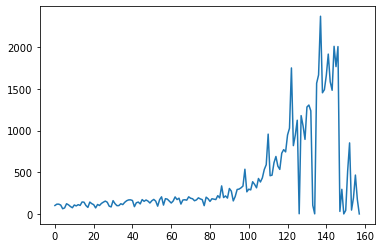

In [331]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('publications.csv', usecols=[0], engine='python')
plt.plot(dataset)
plt.show()

In [299]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [332]:
# load the dataset
dataframe = pandas.read_csv('publications.csv', usecols=[0], engine='python')
dataset = dataframe.values
print(dataset)
dataset = dataset.astype('float32')

[[ 102]
 [ 118]
 [ 118]
 [ 107]
 [  63]
 [  73]
 [ 123]
 [ 110]
 [  90]
 [  75]
 [ 108]
 [  97]
 [ 112]
 [ 103]
 [ 144]
 [ 142]
 [ 102]
 [  79]
 [ 143]
 [ 124]
 [ 112]
 [  73]
 [ 114]
 [ 102]
 [ 127]
 [ 142]
 [ 155]
 [ 141]
 [  94]
 [  85]
 [ 160]
 [ 124]
 [ 100]
 [ 101]
 [ 123]
 [ 113]
 [ 140]
 [ 159]
 [ 169]
 [ 170]
 [ 162]
 [  88]
 [ 135]
 [ 143]
 [ 121]
 [ 173]
 [ 152]
 [ 168]
 [ 155]
 [ 132]
 [ 159]
 [ 175]
 [ 154]
 [  94]
 [ 171]
 [ 206]
 [ 107]
 [ 184]
 [ 178]
 [ 155]
 [ 132]
 [ 156]
 [ 205]
 [ 173]
 [ 190]
 [ 119]
 [ 168]
 [ 171]
 [ 166]
 [ 206]
 [ 189]
 [ 183]
 [ 159]
 [ 169]
 [ 194]
 [ 181]
 [ 172]
 [ 100]
 [ 202]
 [ 183]
 [ 151]
 [ 183]
 [ 178]
 [ 173]
 [ 220]
 [ 193]
 [ 337]
 [ 197]
 [ 217]
 [ 191]
 [ 306]
 [ 274]
 [ 157]
 [ 210]
 [ 294]
 [ 299]
 [ 314]
 [ 335]
 [ 537]
 [ 266]
 [ 298]
 [ 289]
 [ 387]
 [ 355]
 [ 314]
 [ 426]
 [ 384]
 [ 433]
 [ 534]
 [ 591]
 [ 958]
 [ 459]
 [ 466]
 [ 615]
 [ 690]
 [ 574]
 [ 535]
 [ 729]
 [ 772]
 [ 745]
 [ 948]
 [1029]
 [1752]
 [ 820]
 [ 947]


In [333]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [334]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

105 53


In [335]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [336]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [337]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [338]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
103/103 - 1s - loss: 0.0015 - 1s/epoch - 14ms/step
Epoch 2/100
103/103 - 0s - loss: 8.8090e-04 - 79ms/epoch - 767us/step
Epoch 3/100
103/103 - 0s - loss: 8.6278e-04 - 81ms/epoch - 787us/step
Epoch 4/100
103/103 - 0s - loss: 8.5902e-04 - 78ms/epoch - 757us/step
Epoch 5/100
103/103 - 0s - loss: 8.2803e-04 - 77ms/epoch - 748us/step
Epoch 6/100
103/103 - 0s - loss: 8.0863e-04 - 78ms/epoch - 757us/step
Epoch 7/100
103/103 - 0s - loss: 7.8391e-04 - 76ms/epoch - 738us/step
Epoch 8/100
103/103 - 0s - loss: 7.7244e-04 - 76ms/epoch - 738us/step
Epoch 9/100
103/103 - 0s - loss: 7.7853e-04 - 78ms/epoch - 757us/step
Epoch 10/100
103/103 - 0s - loss: 7.3043e-04 - 82ms/epoch - 796us/step
Epoch 11/100
103/103 - 0s - loss: 7.1728e-04 - 81ms/epoch - 787us/step
Epoch 12/100
103/103 - 0s - loss: 7.1390e-04 - 78ms/epoch - 757us/step
Epoch 13/100
103/103 - 0s - loss: 6.7309e-04 - 81ms/epoch - 787us/step
Epoch 14/100
103/103 - 0s - loss: 6.9471e-04 - 87ms/epoch - 845us/step
Epoch 15/100
103/103 -

In [339]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 1ms/step
Train Score: 52.35 RMSE
Test Score: 537.80 RMSE


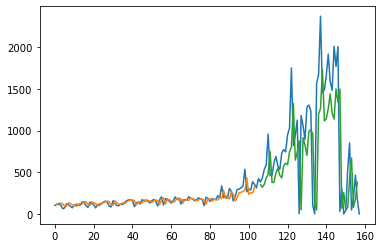

In [340]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/100
94/94 - 1s - loss: 0.0450 - 909ms/epoch - 10ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0222 - 74ms/epoch - 787us/step
Epoch 3/100
94/94 - 0s - loss: 0.0164 - 74ms/epoch - 787us/step
Epoch 4/100
94/94 - 0s - loss: 0.0149 - 74ms/epoch - 787us/step
Epoch 5/100
94/94 - 0s - loss: 0.0140 - 69ms/epoch - 734us/step
Epoch 6/100
94/94 - 0s - loss: 0.0130 - 72ms/epoch - 766us/step
Epoch 7/100
94/94 - 0s - loss: 0.0120 - 71ms/epoch - 755us/step
Epoch 8/100
94/94 - 0s - loss: 0.0110 - 71ms/epoch - 755us/step
Epoch 9/100
94/94 - 0s - loss: 0.0099 - 71ms/epoch - 755us/step
Epoch 10/100
94/94 - 0s - loss: 0.0089 - 71ms/epoch - 755us/step
Epoch 11/100
94/94 - 0s - loss: 0.0079 - 72ms/epoch - 766us/step
Epoch 12/100
94/94 - 0s - loss: 0.0071 - 76ms/epoch - 809us/step
Epoch 13/100
94/94 - 0s - loss: 0.0061 - 75ms/epoch - 798us/step
Epoch 14/100
94/94 - 0s - loss: 0.0054 - 78ms/epoch - 830us/step
Epoch 15/100
94/94 - 0s - loss: 0.0046 - 71ms/epoch - 755us/step
Epoch 16/100
94/94 - 0s - loss: 0.

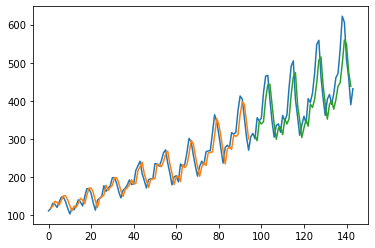

In [341]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/100
92/92 - 1s - loss: 0.0840 - 909ms/epoch - 10ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0397 - 69ms/epoch - 750us/step
Epoch 3/100
92/92 - 0s - loss: 0.0246 - 76ms/epoch - 826us/step
Epoch 4/100
92/92 - 0s - loss: 0.0196 - 78ms/epoch - 848us/step
Epoch 5/100
92/92 - 0s - loss: 0.0172 - 77ms/epoch - 837us/step
Epoch 6/100
92/92 - 0s - loss: 0.0153 - 74ms/epoch - 805us/step
Epoch 7/100
92/92 - 0s - loss: 0.0135 - 70ms/epoch - 761us/step
Epoch 8/100
92/92 - 0s - loss: 0.0119 - 69ms/epoch - 750us/step
Epoch 9/100
92/92 - 0s - loss: 0.0103 - 67ms/epoch - 728us/step
Epoch 10/100
92/92 - 0s - loss: 0.0090 - 71ms/epoch - 772us/step
Epoch 11/100
92/92 - 0s - loss: 0.0077 - 75ms/epoch - 815us/step
Epoch 12/100
92/92 - 0s - loss: 0.0068 - 73ms/epoch - 794us/step
Epoch 13/100
92/92 - 0s - loss: 0.0059 - 73ms/epoch - 794us/step
Epoch 14/100
92/92 - 0s - loss: 0.0052 - 68ms/epoch - 739us/step
Epoch 15/100
92/92 - 0s - loss: 0.0047 - 66ms/epoch - 718us/step
Epoch 16/100
92/92 - 0s - loss: 0.

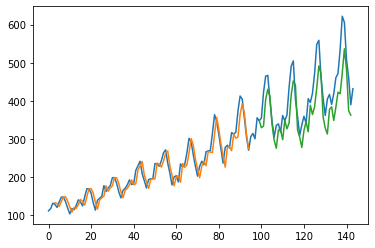

In [342]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()